# Simulations for determining best values of $\lambda$

In [1]:
import numpy
import os

import helpers
import matplotlib

import astropy
from astropy.io import fits

from scipy import signal

from visibilities import *
from rascil.processing_components import export_visibility_to_ms

import matplotlib.pyplot as plt

matplotlib.pyplot.set_loglevel("critical")

cmap = 'turbo'
matplotlib.rcParams['figure.figsize'] = [10, 5]

wavelet_type_dict = {"daubechies" : 0, "iuwt" : 1}

wavelet_type = "daubechies"
wavelet_type_idx = wavelet_type_dict[wavelet_type]

runtests = False
niter = 100

## 3 Ground Truth Images (without noise), taken from Meerkat survey, edges cut and feathered to reduce what appears to be artefacting from nifty

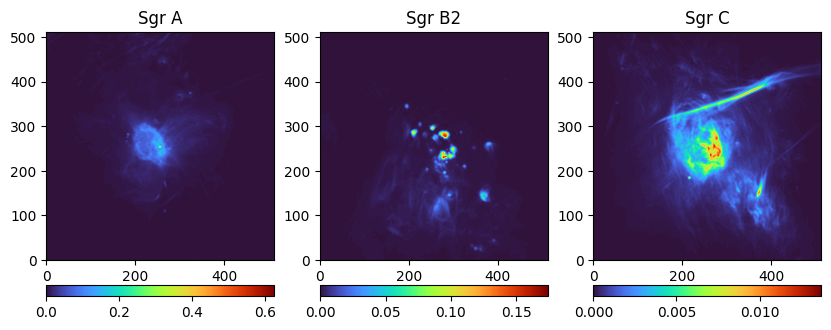

In [2]:
sgra = helpers.readFits("../data/SGRA_full_gt.fits")
sgrb = helpers.readFits("../data/SGRB_full_gt.fits")
sgrc = helpers.readFits("../data/SGRC_full_gt.fits")

helpers.plotNImages([sgra, sgrb, sgrc], ["Sgr A", "Sgr B2", "Sgr C"], cmap)

## Determine number of sample points. Use exponential curve instead of linear to allow for better coverage for lower values of lambda

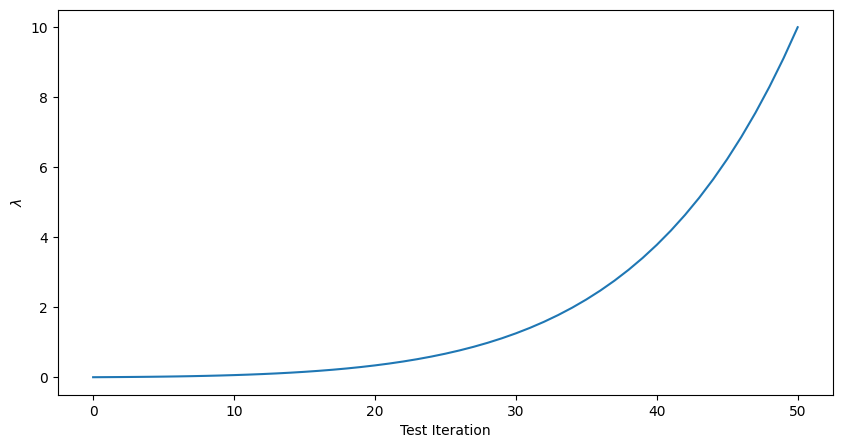

In [3]:
num_samples = 50
lambda_low = 0.001
lambda_high = 10

step = 1 / float(num_samples)

x_vals = numpy.arange(0, 1 + step, step)

lambdas = [0] * len(x_vals)
for i, v in enumerate(x_vals):
    lambdas[i] = helpers.exp_growth(v, lambda_low, lambda_high, steepness = 0.5)
    
helpers.plot1D(range(0, len(lambdas)), lambdas, "Test Iteration", "$\lambda$")

## Test case 1: SGR A full

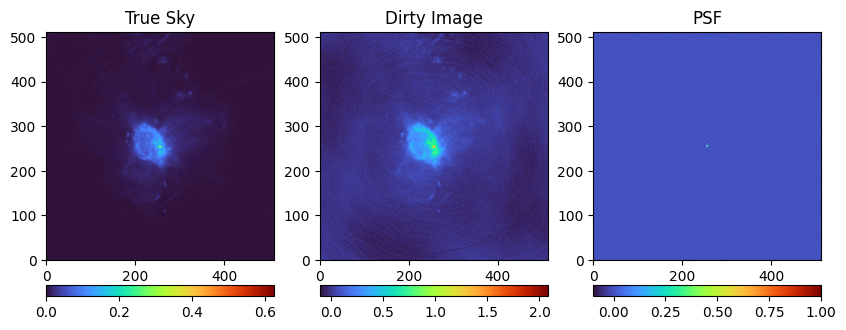

In [4]:
gt = helpers.readFits("../lambda_tests/SGRA_full_gt.fits")
dirty = helpers.readFits("../lambda_tests/SGRA_full_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRA_full_psf.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRA_full/"

Best Lambda 0.3387054058122328 with SNR 13.068424117538502


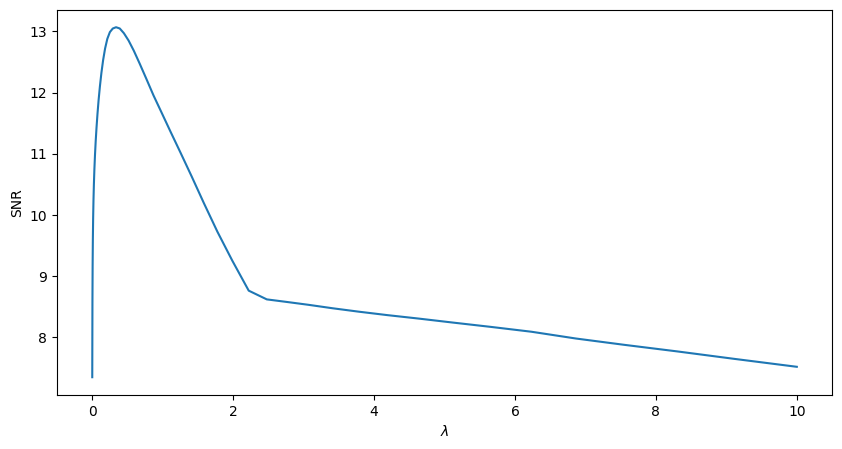

In [5]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

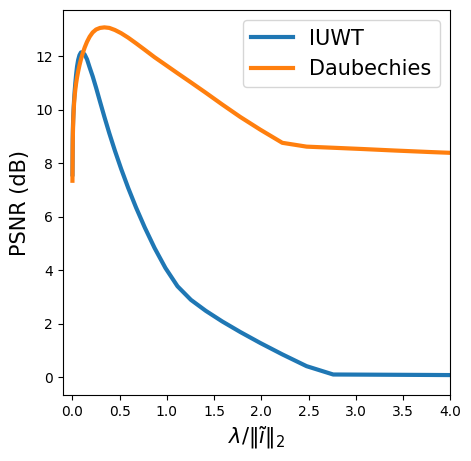

In [6]:
matplotlib.rcParams['figure.figsize'] = [5, 5]

dn = numpy.linalg.norm(dirty)
pathi = "../results/lambda_results/iuwt/SGRA_full/"
pathd = "../results/lambda_results/daubechies/SGRA_full/"

snrsi = helpers.read_csv(pathi + "snr.dat")
snrsd = helpers.read_csv(pathd + "snr.dat")
snrsi = [float(x) for x in snrsi]
snrsd = [float(x) for x in snrsd]

plt.xlim([-0.1, 4])
plt.plot(lambdas, snrsi, lw=3, label='IUWT')
plt.plot(lambdas, snrsd, lw=3, label='Daubechies')
plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"$\lambda / \|\tilde{\imath}\|_2$", fontsize=15)
plt.ylabel("PSNR (dB)", fontsize=15)

plt.savefig("../figures/iuwtvsdaub.png", pad_inches=0.0, bbox_inches='tight')

plt.show()

matplotlib.rcParams['figure.figsize'] = [10, 5]

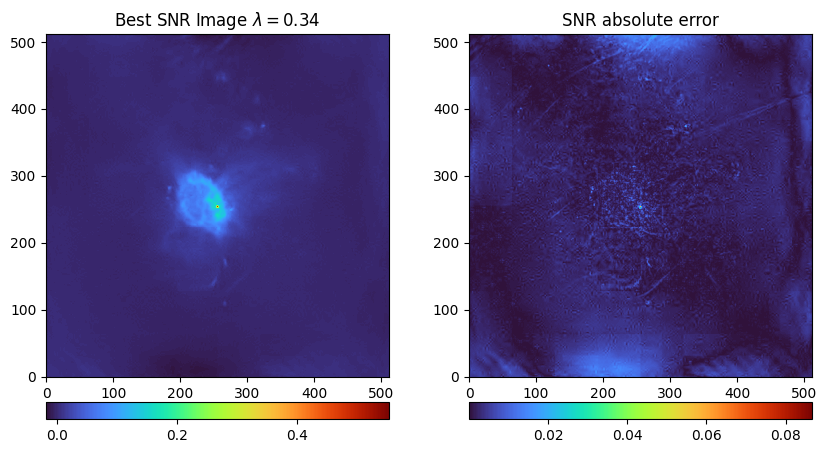

In [7]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

## Test case 2: SGR B2 full

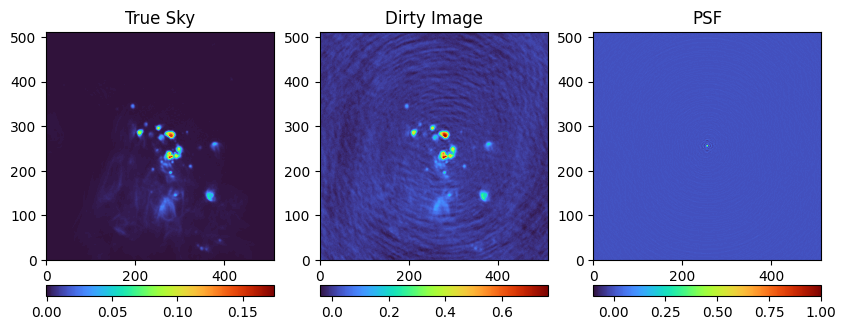

In [8]:
gt = helpers.readFits("../lambda_tests/SGRB_full_gt.fits")
dirty = helpers.readFits("../lambda_tests/SGRB_full_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRB_full_psf.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRB_full/"

Best Lambda 0.10954884560239736 with SNR 12.077553095778233


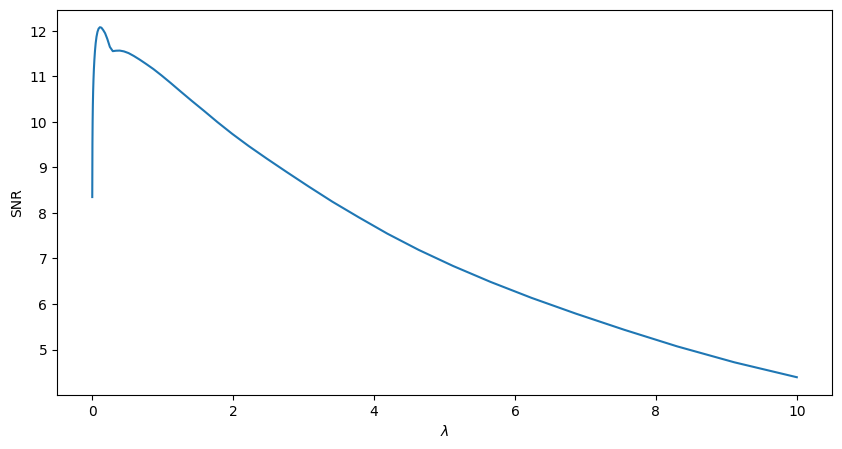

In [9]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

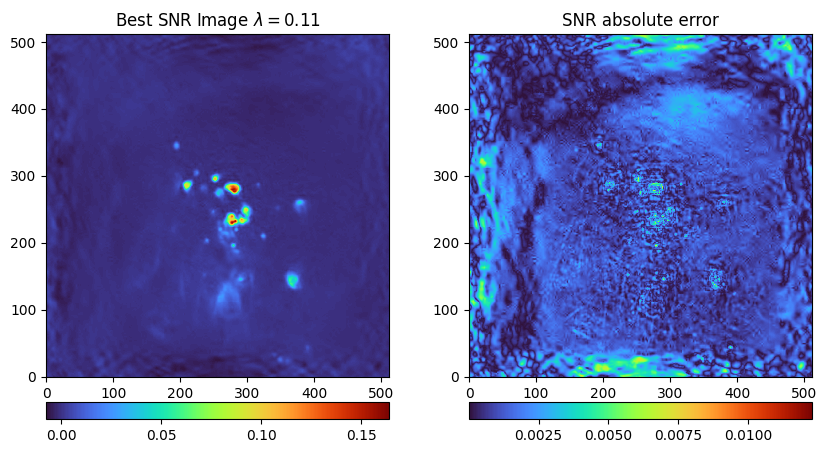

In [10]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

## Test case 3: SGR C full

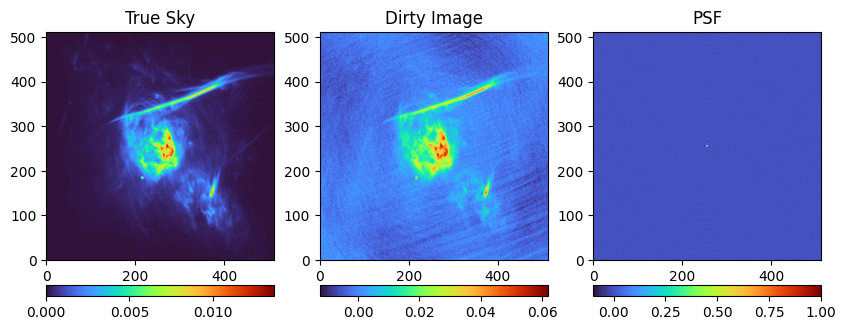

In [11]:
gt = helpers.readFits("../lambda_tests/SGRC_full_gt.fits")
dirty = helpers.readFits("../lambda_tests/SGRC_full_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRC_full_psf.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRC_full/"

Best Lambda 0.031380723676513914 with SNR 7.337311345757933


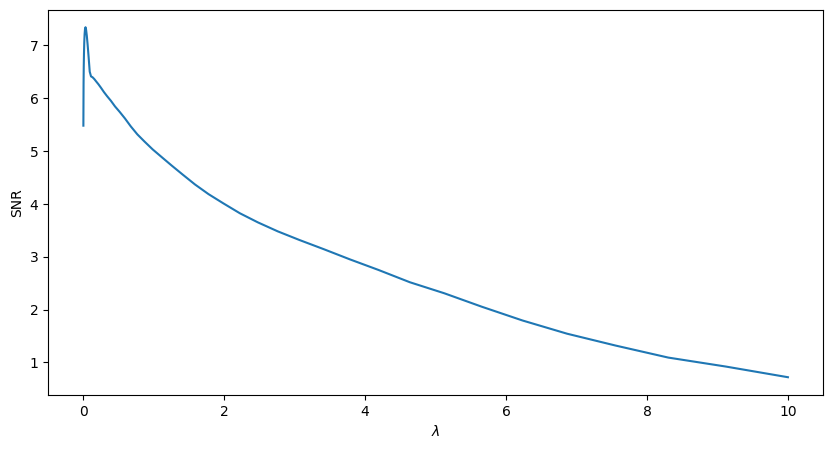

In [12]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

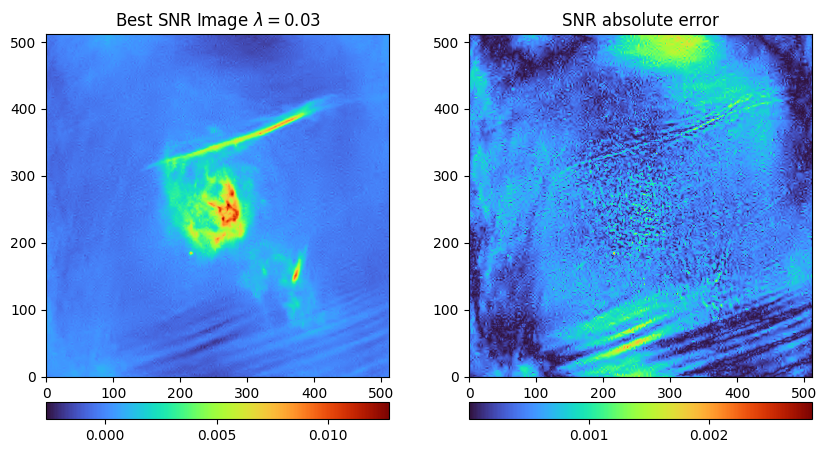

In [13]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

### Normalization by signal amplitudes

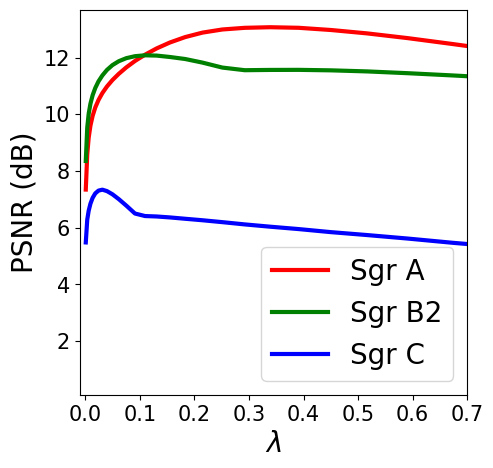

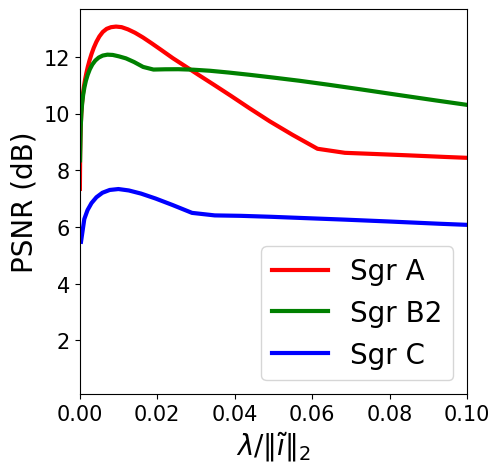

Best lambdas normalized by l2 norm: 
Sgr A: 0.009352321840533273
Sgr B2: 0.007130955956476399
Sgr C: 0.00997681460761734


In [14]:
matplotlib.rcParams['figure.figsize'] = [5, 5]

norm_a = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRA_full_dirty.fits"))
norm_b = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRB_full_dirty.fits"))
norm_c = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRC_full_dirty.fits"))

snrs_a = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRA_full/snr.dat")
snrs_a = [float(x) for x in snrs_a]

snrs_b = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRB_full/snr.dat")
snrs_b = [float(x) for x in snrs_b]

snrs_c = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRC_full/snr.dat")
snrs_c = [float(x) for x in snrs_c]

plt.xlim([-0.01, 0.7])

plt.plot(lambdas, snrs_a, c='r', lw=3, label="Sgr A")
plt.plot(lambdas, snrs_b, c='g', lw=3, label="Sgr B2")
plt.plot(lambdas, snrs_c, c='b', lw=3, label="Sgr C")

plt.xlabel("$\lambda$", fontsize=20)
plt.ylabel("PSNR (dB)", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.legend(loc="lower right", fontsize=20)

plt.savefig("../figures/lambda_1mc_unnorm.png", pad_inches=0.0, bbox_inches='tight')
plt.show()

plt.xlim([0, 0.1])

plt.plot(lambdas / norm_a, snrs_a, c='r', lw=3, label="Sgr A")
plt.plot(lambdas / norm_b, snrs_b, c='g', lw=3, label="Sgr B2")
plt.plot(lambdas / norm_c, snrs_c, c='b', lw=3, label="Sgr C")

plt.xlabel(r"$\lambda / \|\tilde{\imath}\|_2$", fontsize=20)
plt.ylabel("PSNR (dB)", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.legend(loc="lower right", fontsize=20)

plt.savefig("../figures/lambda_1mc_norm.png", pad_inches=0.0, bbox_inches='tight')
plt.show()
mia = numpy.argmax(snrs_a)
mib = numpy.argmax(snrs_b)
mic = numpy.argmax(snrs_c)

print("Best lambdas normalized by l2 norm: ")
print("Sgr A: " + str(lambdas[mia] / norm_a))
print("Sgr B2: " + str(lambdas[mib] / norm_b))
print("Sgr C: " + str(lambdas[mic] / norm_c))

matplotlib.rcParams['figure.figsize'] = [10, 5]

## Test case 4: SGR A short baselines

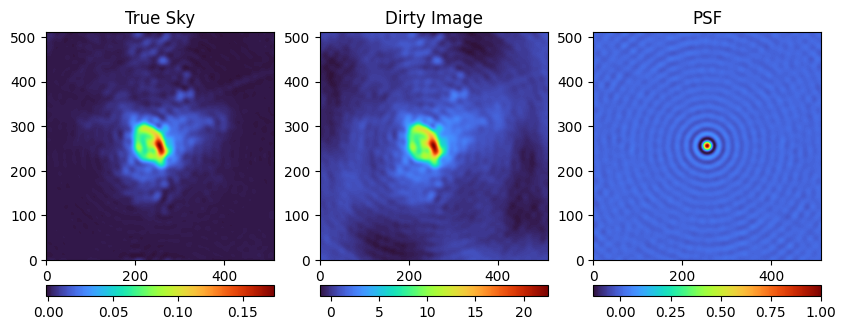

In [15]:
dirty = helpers.readFits("../data/SGRA_low25_dirty.fits")
psf = helpers.readFits("../data/SGRA_low25_psf.fits")
gt = helpers.readFits("../data/SGRA_low25_gt.fits")

path = "../results/lambda_results/" + wavelet_type + "/SGRA_low25/"
lpfilter = helpers.bandpass(gt, 0, 25)

helpers.plotGDP(gt, dirty, psf, cmap)

os.makedirs(path, exist_ok=True)

Best Lambda 10.0 with SNR 15.878457272673675


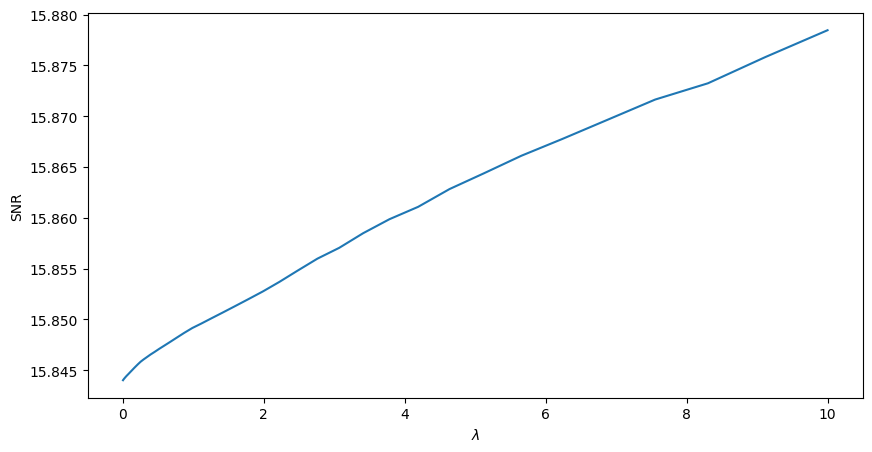

In [16]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests, lp_filter=lpfilter)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

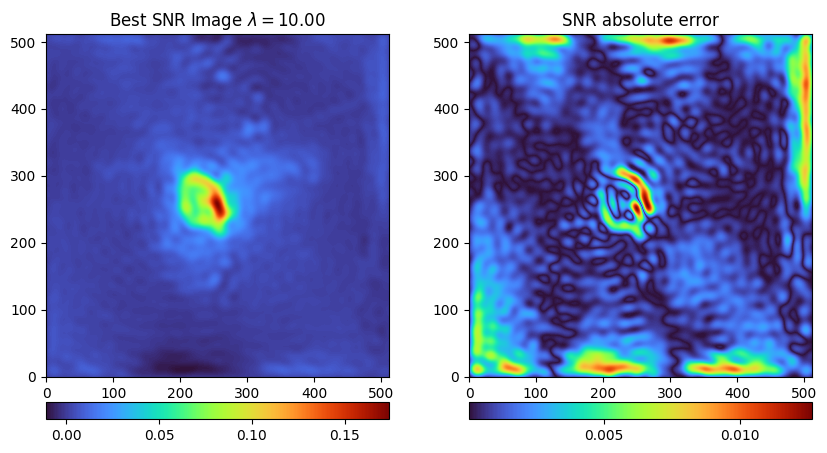

In [17]:
snr_fn = path + "lambda_" + str(lambdas[max_snr_idx]) + ".fits"
deconvimage = helpers.readFits(snr_fn)
snrfile = signal.fftconvolve(deconvimage, lpfilter, mode='same')
err_snr = numpy.abs(signal.fftconvolve(gt - snrfile, lpfilter, mode='same'))
snr_title = "Best SNR Image $\lambda = " + "{:.2f}".format(lambdas[max_snr_idx]) + "$"

helpers.plotNImages([snrfile, err_snr], [snr_title, "SNR absolute error"], cmap)

## Test case 5: SGR B2 short baselines

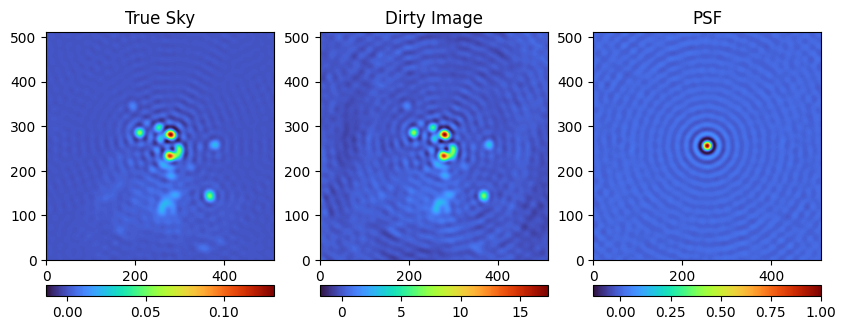

In [18]:
dirty = helpers.readFits("../data/SGRB_low25_dirty.fits")
psf = helpers.readFits("../data/SGRB_low25_psf.fits")
gt = helpers.readFits("../data/SGRB_low25_gt.fits")

path = "../results/lambda_results/" + wavelet_type + "/SGRB_low25/"
bpfilter = helpers.bandpass(gt, 0, 25)

helpers.plotGDP(gt, dirty, psf, cmap)

os.makedirs(path, exist_ok=True)

Best Lambda 10.0 with SNR 14.359994533461347


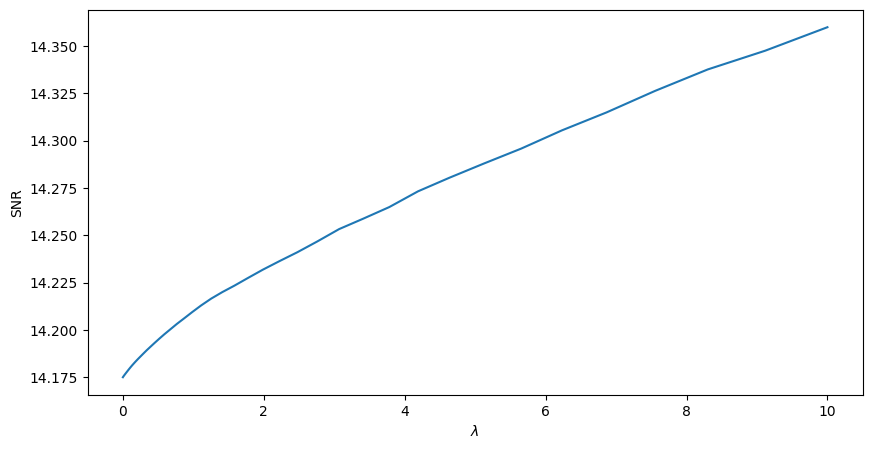

In [19]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests, lp_filter=lpfilter)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

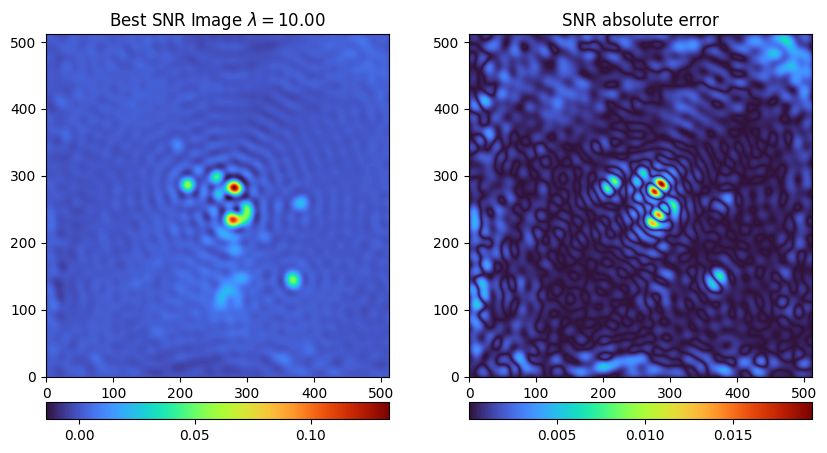

In [20]:
snr_fn = path + "lambda_" + str(lambdas[max_snr_idx]) + ".fits"
deconvimage = helpers.readFits(snr_fn)
snrfile = signal.fftconvolve(deconvimage, lpfilter, mode='same')
err_snr = numpy.abs(signal.fftconvolve(gt - snrfile, lpfilter, mode='same'))
snr_title = "Best SNR Image $\lambda = " + "{:.2f}".format(lambdas[max_snr_idx]) + "$"

helpers.plotNImages([snrfile, err_snr], [snr_title, "SNR absolute error"], cmap)

## Test case 6: SGR C short baselines

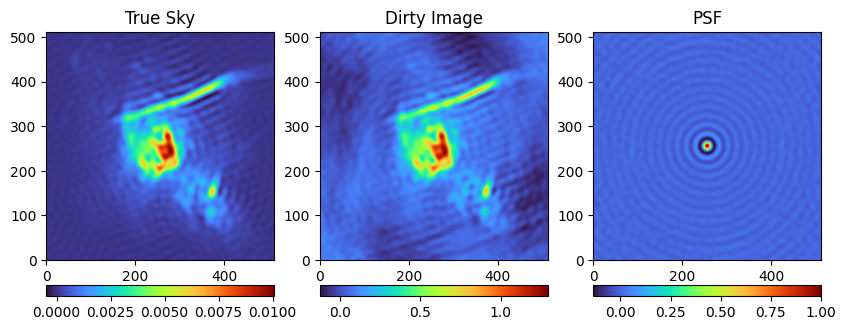

In [21]:
dirty = helpers.readFits("../data/SGRC_low25_dirty.fits")
psf = helpers.readFits("../data/SGRC_low25_psf.fits")
gt = helpers.readFits("../data/SGRC_low25_gt.fits")

path = "../results/lambda_results/" + wavelet_type + "/SGRC_low25/"
bpfilter = helpers.bandpass(gt, 0, 25)

helpers.plotGDP(gt, dirty, psf, cmap)

os.makedirs(path, exist_ok=True)

Best Lambda 10.0 with SNR 12.461329399739311


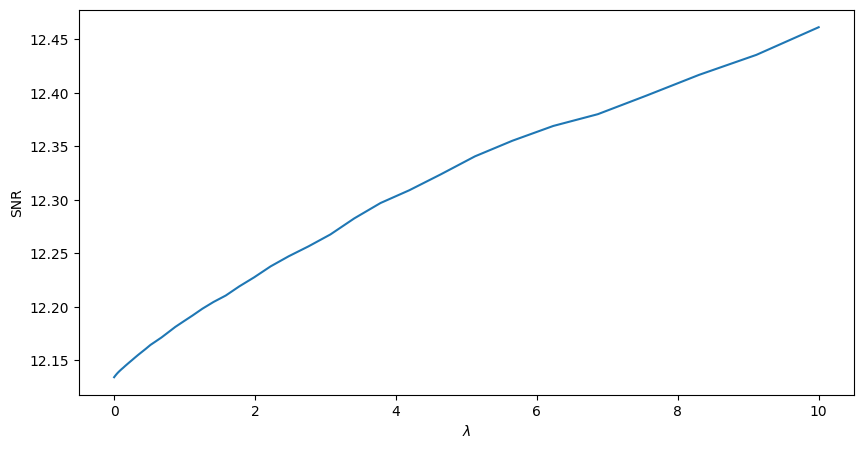

In [22]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests, lp_filter=lpfilter)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

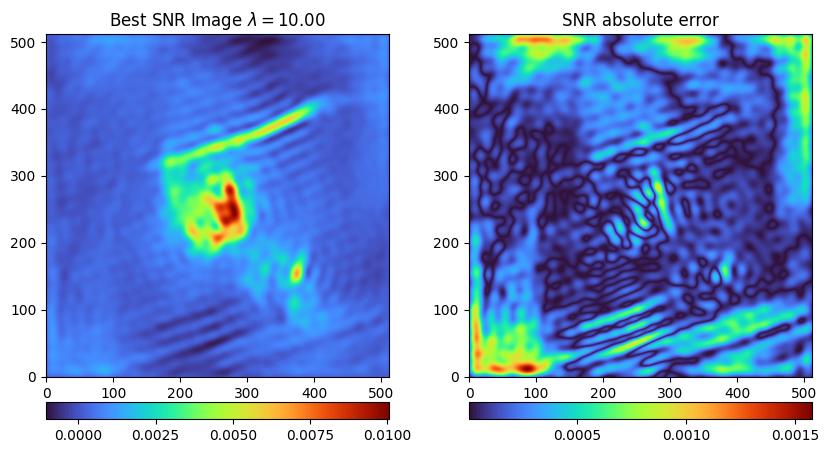

In [23]:
snr_fn = path + "lambda_" + str(lambdas[max_snr_idx]) + ".fits"
deconvimage = helpers.readFits(snr_fn)
snrfile = signal.fftconvolve(deconvimage, lpfilter, mode='same')
err_snr = numpy.abs(signal.fftconvolve(gt - snrfile, lpfilter, mode='same'))
snr_title = "Best SNR Image $\lambda = " + "{:.2f}".format(lambdas[max_snr_idx]) + "$"

helpers.plotNImages([snrfile, err_snr], [snr_title, "SNR absolute error"], cmap)

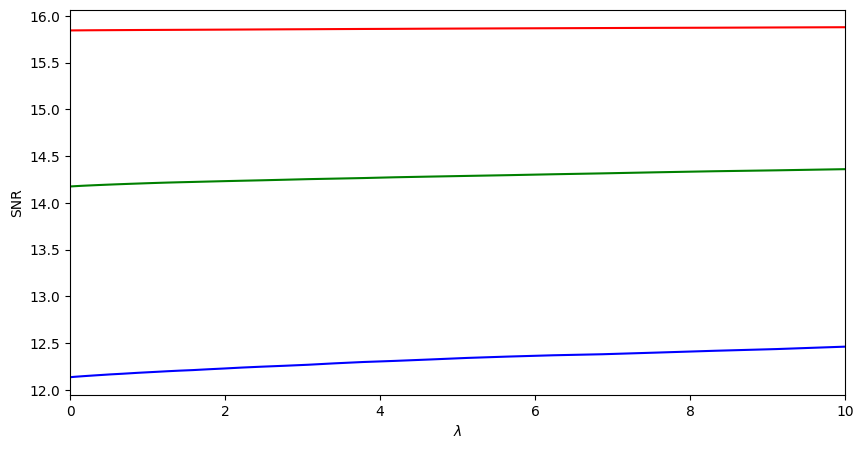

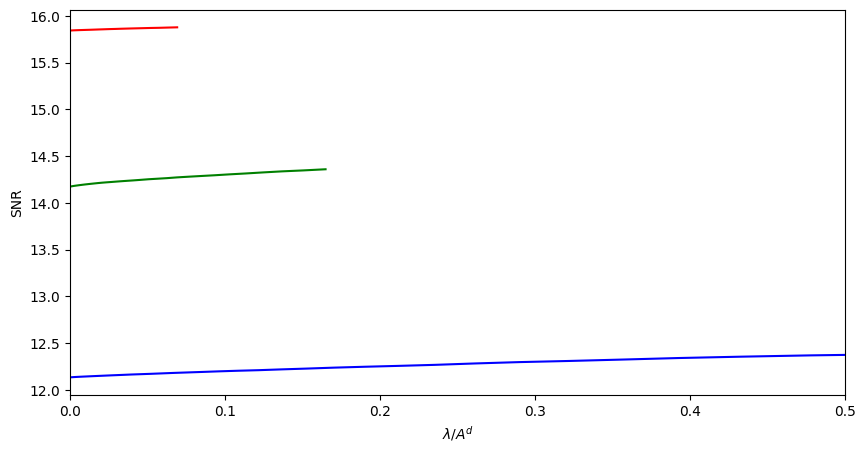

Best lambdas normalized by l2 norm: 
Sgr A: 0.0690426878275582
Sgr B2: 0.16477827416557334
Sgr C: 0.7663595912123414


In [24]:
norm_a = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRA_short_dirty.fits"))
norm_b = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRB_short_dirty.fits"))
norm_c = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRC_short_dirty.fits"))

snrs_a = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRA_low25/snr.dat")
snrs_a = [float(x) for x in snrs_a]

snrs_b = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRB_low25/snr.dat")
snrs_b = [float(x) for x in snrs_b]

snrs_c = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRC_low25/snr.dat")
snrs_c = [float(x) for x in snrs_c]

plt.xlim([0, 10])

plt.plot(lambdas, snrs_a, c='r')
plt.plot(lambdas, snrs_b, c='g')
plt.plot(lambdas, snrs_c, c='b')

plt.xlabel("$\lambda$")
plt.ylabel("SNR")

plt.show()

plt.xlim([0, 0.5])

plt.plot(lambdas / norm_a, snrs_a, c='r')
plt.plot(lambdas / norm_b, snrs_b, c='g')
plt.plot(lambdas / norm_c, snrs_c, c='b')
plt.xlabel("$\lambda / A^{d}$")
plt.ylabel("SNR")
plt.show()

mia = numpy.argmax(snrs_a)
mib = numpy.argmax(snrs_b)
mic = numpy.argmax(snrs_c)

print("Best lambdas normalized by l2 norm: ")
print("Sgr A: " + str(lambdas[mia] / norm_a))
print("Sgr B2: " + str(lambdas[mib] / norm_b))
print("Sgr C: " + str(lambdas[mic] / norm_c))

## Test case 7: SGR A multi-step

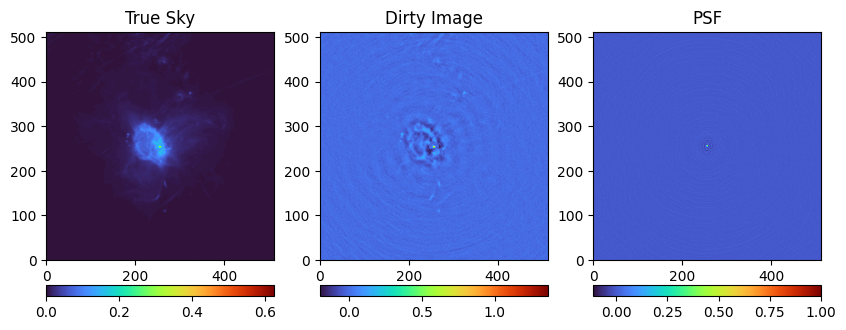

In [25]:
dirty = helpers.readFits("../data/SGRA_high15_dirty.fits")
psf = helpers.readFits("../data/SGRA_high15_psf.fits")
gt = helpers.readFits("../data/SGRA_full_gt.fits")
lowres = helpers.readFits("../data/SGRA_low25_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRA_multistep/"

Best Lambda 0.5163355092778862 with SNR 23.47199664318861


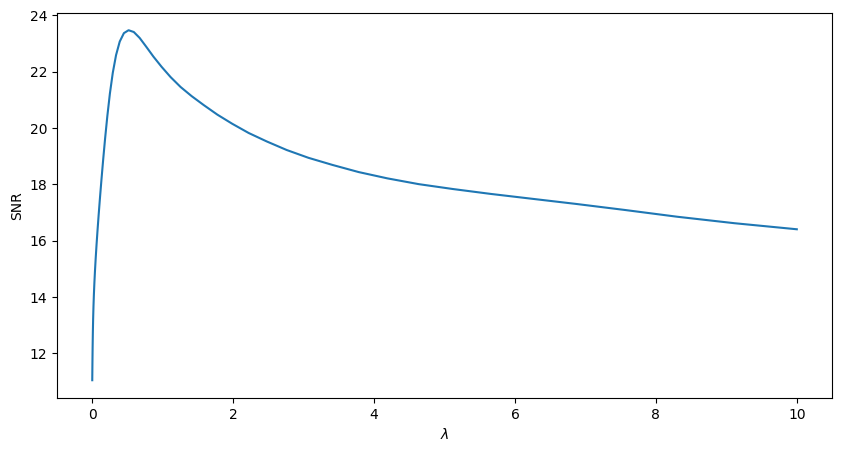

In [26]:
snrs = helpers.lambdatests_highvis(lambdas, path, dirty, psf, gt, lowres, wavelet_type_idx, niter, 25, 5, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

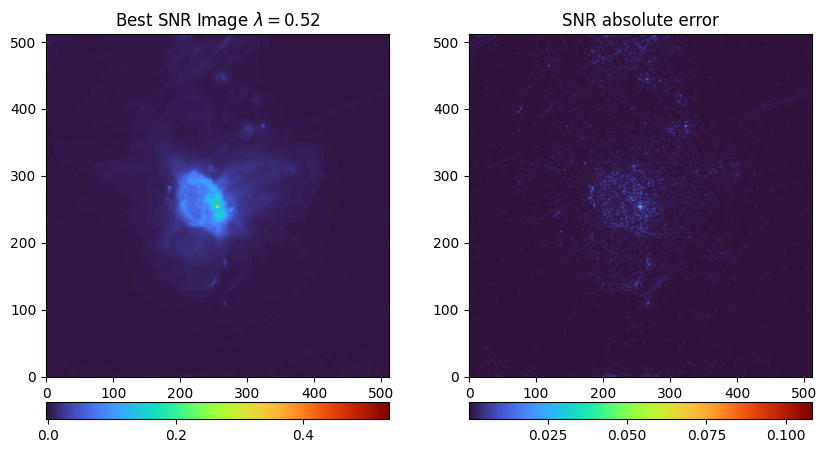

In [27]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

## Test case 8: SGR B2 multi-step

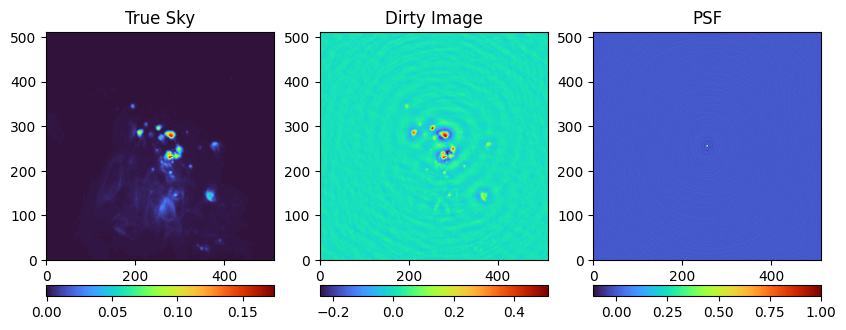

In [28]:
dirty = helpers.readFits("../data/SGRB_high15_dirty.fits")
psf = helpers.readFits("../data/SGRB_high15_psf.fits")
gt = helpers.readFits("../data/SGRB_full_gt.fits")
lowres = helpers.readFits("../data/SGRB_low25_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRB_multistep/"

Best Lambda 0.21497143619925183 with SNR 21.100192384014207


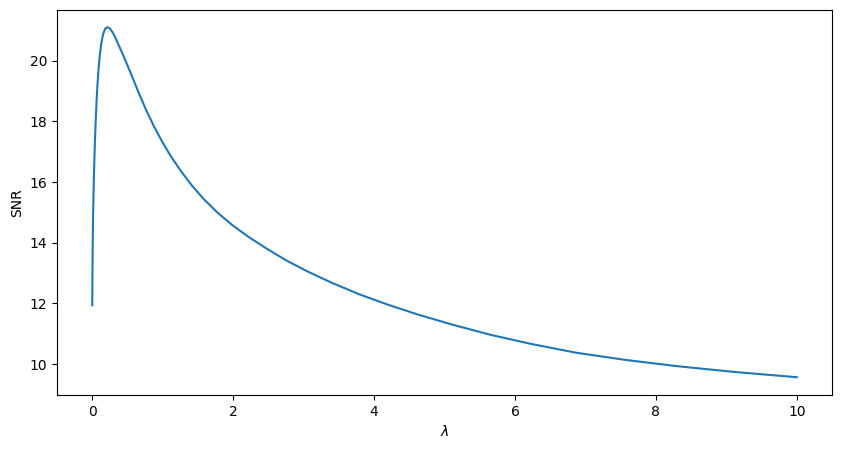

In [29]:
snrs = helpers.lambdatests_highvis(lambdas, path, dirty, psf, gt, lowres, wavelet_type_idx, niter, 25, 5, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

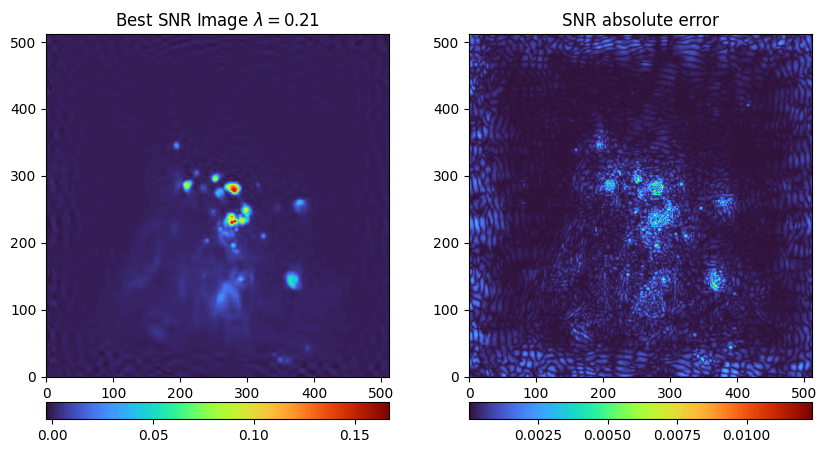

In [30]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

## Test case 9: SGR C multi-step

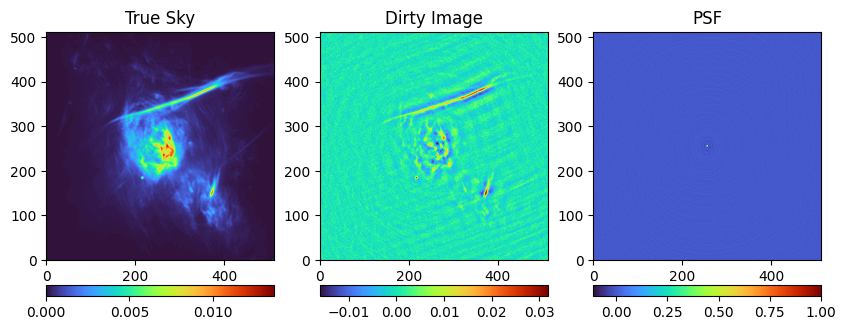

In [31]:
dirty = helpers.readFits("../data/SGRC_high15_dirty.fits")
psf = helpers.readFits("../data/SGRC_high15_psf.fits")
gt = helpers.readFits("../data/SGRC_full_gt.fits")
lowres = helpers.readFits("../data/SGRC_low25_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRC_multistep/"

Best Lambda 0.061497063981206315 with SNR 21.028838520519912


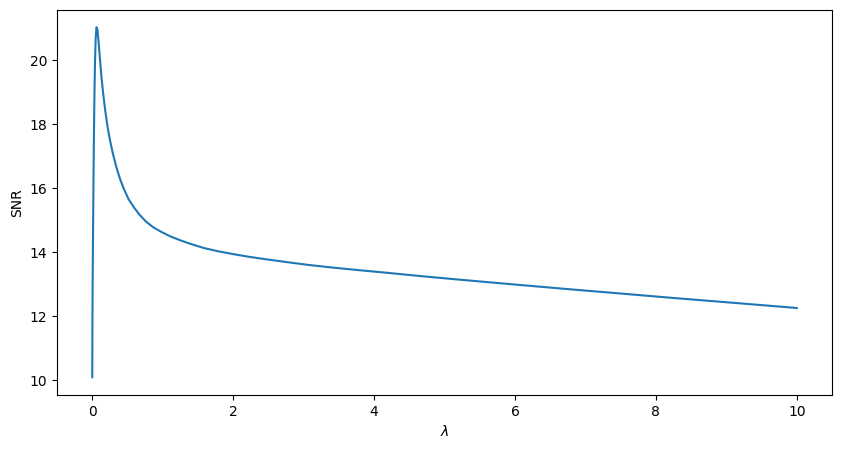

In [32]:
snrs = helpers.lambdatests_highvis(lambdas, path, dirty, psf, gt, lowres, wavelet_type_idx, niter, 25, 5, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

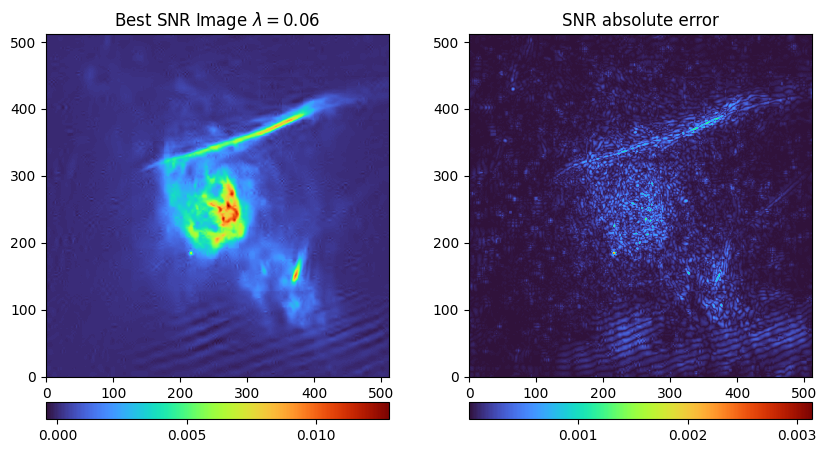

In [33]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

In [34]:
norm_a = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRA_long_dirty.fits"))
norm_b = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRB_long_dirty.fits"))
norm_c = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRC_long_dirty.fits"))

snrs_a = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRA_multistep/snr.dat")
snrs_a = [float(x) for x in snrs_a]

snrs_b = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRB_multistep/snr.dat")
snrs_b = [float(x) for x in snrs_b]

snrs_c = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRC_multistep/snr.dat")
snrs_c = [float(x) for x in snrs_c]

plt.xlim([0, 10])

plt.plot(lambdas, snrs_a, c='r')
plt.plot(lambdas, snrs_b, c='g')
plt.plot(lambdas, snrs_c, c='b')

plt.xlabel("$\lambda$")
plt.ylabel("SNR")

plt.show()

plt.xlim([0, 0.3])

plt.plot(lambdas / norm_a, snrs_a, c='r')
plt.plot(lambdas / norm_b, snrs_b, c='g')
plt.plot(lambdas / norm_c, snrs_c, c='b')
plt.xlabel("$\lambda / A^{d}$")
plt.ylabel("SNR")
plt.show()

mia = numpy.argmax(snrs_a)
mib = numpy.argmax(snrs_b)
mic = numpy.argmax(snrs_c)

print("Best lambdas normalized by l2 norm: ")
print("Sgr A: " + str(lambdas[mia] / norm_a))
print("Sgr B2: " + str(lambdas[mib] / norm_b))
print("Sgr C: " + str(lambdas[mic] / norm_c))

FileNotFoundError: [Errno 2] No such file or directory: 'lambda_tests/SGRA_long_dirty.fits'

## Test case 10: SGR A first residual

In [ ]:
dirty = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_firstresid_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRA_full_psf.fits")
sky = helpers.readFits("../lambda_tests/SGRA_full_gt.fits")
prev_deconv = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_firstresid_deconv.fits")
gt = sky - prev_deconv

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRA_firstresid/"

In [ ]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap, same_scale=True)

## Test case 12: SGR B2 first residual

In [ ]:
dirty = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_firstresid_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRB_full_psf.fits")
sky = helpers.readFits("../lambda_tests/SGRB_full_gt.fits")
prev_deconv = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_firstresid_deconv.fits")
gt = sky - prev_deconv

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRB_firstresid/"

In [ ]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, 0, gt, cmap)

## Test case 14: SGR C first residual

In [ ]:
dirty = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_firstresid_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRC_full_psf.fits")
sky = helpers.readFits("../lambda_tests/SGRC_full_gt.fits")
prev_deconv = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_firstresid_deconv.fits")
gt = sky - prev_deconv

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRC_firstresid/"

In [ ]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

In [ ]:
lower = helpers.readFits("../results/lambda_results/" + wavelet_type + "/SGRC_firstresid/lambda_" + str(lambdas[5]) + ".fits")
higher = helpers.readFits("../results/lambda_results/" + wavelet_type + "/SGRC_firstresid/lambda_" + str(lambdas[max_snr_idx]) + ".fits")

err_lower = numpy.abs(gt - lower)
err_higher = numpy.abs(gt - higher)

snr_lower = helpers.compute_snr(gt, lower)
snr_higher = helpers.compute_snr(gt, higher)

print("Lower: " + str(snr_lower) + " " + str(lambdas[5]))
print("Upper: " + str(snr_higher) + " " + str(lambdas[max_snr_idx]))

helpers.plotNImages([lower], \
                    [""], additional_scale_imgs=[higher], hide_ticks=True,\
                     cmap=cmap, same_scale=True, output_file="../figures/firstresid_diflambda_low.png")

helpers.plotNImages([higher], \
                    [""], additional_scale_imgs=[lower], hide_ticks=True,\
                   cmap=cmap, same_scale=True, output_file="../figures/firstresid_diflambda_high.png")

helpers.plotNImages([err_lower], \
                    [""], hide_ticks=True,\
                   cmap=cmap, same_scale=True, output_file="../figures/firstresid_diflambda_err_low.png",\
                   additional_scale_imgs=[err_higher])
helpers.plotNImages([err_higher], \
                    [""], additional_scale_imgs=[err_lower], hide_ticks=True,\
                   cmap=cmap, same_scale=True, output_file="../figures/firstresid_diflambda_err_high.png")

## Test case 11: SGR A second residual

In [ ]:
dirty = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_secondresid_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRA_full_psf.fits")
sky = helpers.readFits("../lambda_tests/SGRA_full_gt.fits")
deconv1 = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_firstresid_deconv.fits")
deconv2 = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_secondresid_deconv.fits")
gt = sky - deconv1 - deconv2

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRA_secondresid/"

In [ ]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

## Test case 13: SGR B2 second residual

In [ ]:
dirty = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_secondresid_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRB_full_psf.fits")
sky = helpers.readFits("../lambda_tests/SGRB_full_gt.fits")
deconv1 = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_firstresid_deconv.fits")
deconv2 = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_secondresid_deconv.fits")
gt = sky - deconv1 - deconv2

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRB_secondresid/"

In [ ]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

## Test case 15: SGR C second residual

In [ ]:
dirty = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_secondresid_dirty.fits")
psf = helpers.readFits("../lambda_tests/SGRC_full_psf.fits")
sky = helpers.readFits("../lambda_tests/SGRC_full_gt.fits")
deconv1 = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_firstresid_deconv.fits")
deconv2 = helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_secondresid_deconv.fits")
gt = sky - deconv1 - deconv2

helpers.plotGDP(gt, dirty, psf, cmap)

path = "../results/lambda_results/" + wavelet_type + "/SGRC_secondresid/"

In [ ]:
snrs = helpers.lambdatests_allvis(lambdas, path, dirty, psf, gt, wavelet_type_idx, niter, runtests)
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda " + str(lambdas[max_snr_idx]) + " with SNR " + str(snrs[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, gt, cmap)

In [ ]:
norm_a = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_firstresid_dirty.fits"))
norm_b = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_firstresid_dirty.fits"))
norm_c = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_firstresid_dirty.fits"))

snrs_a = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRA_firstresid/snr.dat")
snrs_a = [float(x) for x in snrs_a]

snrs_b = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRB_firstresid/snr.dat")
snrs_b = [float(x) for x in snrs_b]

snrs_c = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRC_firstresid/snr.dat")
snrs_c = [float(x) for x in snrs_c]

plt.xlim([0, 10])

plt.plot(lambdas, snrs_a, c='r')
plt.plot(lambdas, snrs_b, c='g')
plt.plot(lambdas, snrs_c, c='b')

plt.xlabel("$\lambda$")
plt.ylabel("SNR")

plt.show()

plt.xlim([0, 1])

plt.plot(lambdas / norm_a, snrs_a, c='r')
plt.plot(lambdas / norm_b, snrs_b, c='g')
plt.plot(lambdas / norm_c, snrs_c, c='b')
plt.xlabel("$\lambda / A^{d}$")
plt.ylabel("SNR")
plt.show()

mia = numpy.argmax(snrs_a)
mib = numpy.argmax(snrs_b)
mic = numpy.argmax(snrs_c)

print("Best lambdas normalized by l2 norm: ")
print("Sgr A: " + str(lambdas[mia] / norm_a))
print("Sgr B2: " + str(lambdas[mib] / norm_b))
print("Sgr C: " + str(lambdas[mic] / norm_c))

In [ ]:
norm_a = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_secondresid_dirty.fits"))
norm_b = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_secondresid_dirty.fits"))
norm_c = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_secondresid_dirty.fits"))

snrs_a = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRA_secondresid/snr.dat")
snrs_a = [float(x) for x in snrs_a]

snrs_b = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRB_secondresid/snr.dat")
snrs_b = [float(x) for x in snrs_b]

snrs_c = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRC_secondresid/snr.dat")
snrs_c = [float(x) for x in snrs_c]

plt.xlim([0, 10])

plt.plot(lambdas, snrs_a, c='r')
plt.plot(lambdas, snrs_b, c='g')
plt.plot(lambdas, snrs_c, c='b')

plt.xlabel("$\lambda$")
plt.ylabel("SNR")

plt.show()

plt.xlim([0, 0.2])

plt.plot(lambdas / norm_a, snrs_a, c='r')
plt.plot(lambdas / norm_b, snrs_b, c='g')
plt.plot(lambdas / norm_c, snrs_c, c='b')
plt.xlabel("$\lambda / A^{d}$")
plt.ylabel("SNR")
plt.show()

mia = numpy.argmax(snrs_a)
mib = numpy.argmax(snrs_b)
mic = numpy.argmax(snrs_c)

print("Best lambdas normalized by l2 norm: ")
print("Sgr A: " + str(lambdas[mia] / norm_a))
print("Sgr B2: " + str(lambdas[mib] / norm_b))
print("Sgr C: " + str(lambdas[mic] / norm_c))

In [ ]:
matplotlib.rcParams['figure.figsize'] = [6, 5]

norm_a1 = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRA_full_dirty.fits"))
norm_b1 = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRB_full_dirty.fits"))
norm_c1 = numpy.linalg.norm(helpers.readFits("../lambda_tests/SGRC_full_dirty.fits"))

norm_a2 = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_firstresid_dirty.fits"))
norm_b2 = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_firstresid_dirty.fits"))
norm_c2 = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_firstresid_dirty.fits"))

norm_a3 = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRA_secondresid_dirty.fits"))
norm_b3 = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRB_secondresid_dirty.fits"))
norm_c3 = numpy.linalg.norm(helpers.readFits("../lambda_tests/" + wavelet_type + "/SGRC_secondresid_dirty.fits"))

snrs_a1 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRA_full/snr.dat")
snrs_a1 = [float(x) for x in snrs_a1]
snrs_b1 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRB_full/snr.dat")
snrs_b1 = [float(x) for x in snrs_b1]
snrs_c1 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRC_full/snr.dat")
snrs_c1 = [float(x) for x in snrs_c1]

snrs_a2 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRA_firstresid/snr.dat")
snrs_a2 = [float(x) for x in snrs_a2]
snrs_b2 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRB_firstresid/snr.dat")
snrs_b2 = [float(x) for x in snrs_b2]
snrs_c2 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRC_firstresid/snr.dat")
snrs_c2 = [float(x) for x in snrs_c2]

snrs_a3 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRA_secondresid/snr.dat")
snrs_a3 = [float(x) for x in snrs_a3]
snrs_b3 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRB_secondresid/snr.dat")
snrs_b3 = [float(x) for x in snrs_b3]
snrs_c3 = helpers.read_csv("../results/lambda_results/" + wavelet_type + "/SGRC_secondresid/snr.dat")
snrs_c3 = [float(x) for x in snrs_c3]

plt.xlim([-0.01, 0.5])
plt.ylim([-0.5, 1.1])

plt.plot(lambdas / norm_a1, snrs_a1 / numpy.max(snrs_a1), 'r-', label="$n=1$", lw=3)
plt.plot(lambdas / norm_a2, snrs_a2 / numpy.max(snrs_a2), 'r--', label="$n=2$", lw=3)
plt.plot(lambdas / norm_a3, snrs_a3 / numpy.max(snrs_a3), 'r:', label="$n=3$", lw=3)


plt.xlabel(r"$\lambda / \|\tilde{\imath}_n\|_2$", fontsize=15)
plt.ylabel("Normalized PSNR", fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.savefig("../figures/lambdamajcyc.png", pad_inches=0.0, bbox_inches='tight')
plt.show()


matplotlib.rcParams['figure.figsize'] = [10, 5]